## Let's implement CCS from scratch.
This will deliberately be a simple (but less efficient) implementation to make everything as clear as possible.

In [1]:
# my cool cool imports
import matplotlib.pyplot as plt
import random
import pickle

In [2]:
from tqdm import tqdm
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, AutoModelForMaskedLM, AutoModelForCausalLM
from sklearn.linear_model import LogisticRegression

# Let's just try IMDB for simplicity
data = load_dataset("amazon_polarity")["test"]

/opt/conda/envs/ccs2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# manually executes model choice!
model_type = "encoder"
MODEL_NAME = "microsoft/deberta-v2-xxlarge"
# MODEL_NAME = "microsoft/deberta-v3-large"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForMaskedLM.from_pretrained(MODEL_NAME)
model.cuda()

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


## First let's write code for extracting hidden states given a model and text. 
How we do this exactly will depend on the type of model.

In [5]:
def get_encoder_hidden_states(model, tokenizer, input_text, layer=-1):
    """
    Given an encoder model and some text, gets the encoder hidden states (in a given layer, by default the last) 
    on that input text (where the full text is given to the encoder).

    Returns a numpy array of shape (hidden_dim,)
    """
    # tokenize
    encoder_text_ids = tokenizer(input_text, truncation=True, return_tensors="pt").input_ids.to(model.device)

    # forward pass
    with torch.no_grad():
        output = model(encoder_text_ids, output_hidden_states=True)

    # get the appropriate hidden states
    hs_tuple = output["hidden_states"]
    
    hs = hs_tuple[layer][0, -1].detach().cpu().numpy()

    return hs

def get_encoder_decoder_hidden_states(model, tokenizer, input_text, layer=-1):
    """
    Given an encoder-decoder model and some text, gets the encoder hidden states (in a given layer, by default the last) 
    on that input text (where the full text is given to the encoder).

    Returns a numpy array of shape (hidden_dim,)
    """
    # tokenize
    encoder_text_ids = tokenizer(input_text, return_tensors="pt").input_ids.to(model.device)
    decoder_text_ids = tokenizer("", return_tensors="pt").input_ids.to(model.device)

    # forward pass
    with torch.no_grad():
        output = model(encoder_text_ids, decoder_input_ids=decoder_text_ids, output_hidden_states=True)

    # get the appropriate hidden states
    hs_tuple = output["encoder_hidden_states"]
    hs = hs_tuple[layer][0, -1].detach().cpu().numpy()

    return hs

def get_decoder_hidden_states(model, tokenizer, input_text, layer=-1):
    """
    Given a decoder model and some text, gets the hidden states (in a given layer, by default the last) on that input text

    Returns a numpy array of shape (hidden_dim,)
    """
    # tokenize (adding the EOS token this time)
    input_ids = tokenizer(input_text + tokenizer.eos_token, return_tensors="pt").input_ids.to(model.device)

    # forward pass
    with torch.no_grad():
        output = model(input_ids, output_hidden_states=True)

    # get the last layer, last token hidden states
    hs_tuple = output["hidden_states"]
    hs = hs_tuple[layer][0, -1].detach().cpu().numpy()

    return hs

def get_hidden_states(model, tokenizer, input_text, layer=-1, model_type="encoder"):
    fn = {"encoder": get_encoder_hidden_states, "encoder_decoder": get_encoder_decoder_hidden_states,
          "decoder": get_decoder_hidden_states}[model_type]

    return fn(model, tokenizer, input_text, layer=layer)

In [6]:
# specifies embedding fn
# default model_type = "encoder" is fine, since we use deberta
EMBEDDING_FN = lambda input_text: get_hidden_states(model, tokenizer, input_text)

## Now let's write code for formatting data and for getting all the hidden states.

In [7]:
# prompt scaffolding for IMDB dataset
# included in base CCS implementation
def format_imdb(text, label):
    """
    Given an imdb example ("text") and corresponding label (0 for negative, or 1 for positive), 
    returns a zero-shot prompt for that example (which includes that label as the answer).
    
    (This is just one example of a simple, manually created prompt.)
    """
    return "The following movie review expresses a " + ["negative", "positive"][label] + " sentiment:\n" + text

In [8]:
# featurizer for supervised CCS
def featurizer_benchmark(text):
    return EMBEDDING_FN(format_imdb(text, 1)) - EMBEDDING_FN(format_imdb(text, 0))

In [9]:
# specifies featurizer fn
FEATURIZER_FN = featurizer_benchmark

In [11]:
# subsamples dataset
N = 1000
subsample = data[np.random.choice(len(data), N, replace=False)]

In [ ]:
# featurizes subsample
X = np.array([FEATURIZER_FN(text) for text in tqdm(subsample["content"])])
y = np.array(subsample["label"])

100%|██████████| 1000/1000 [04:44<00:00,  3.51it/s]


In [8]:
# pickles and saves X
# pickle.dump(X, open('X.pkl', 'wb'))

# reads X from pickle
# X = pickle.load(open('X.pkl', 'rb'))

In [ ]:
# gets difference of means
exgy = X[y == 1].mean(axis = 0)
exgn = X[y == 0].mean(axis = 0)
diff = exgy - exgn

# Metrics
- salience (proportion of X explained by diff)
<!-- - power (proportion of y explained by diff) -->
- accuracy (proportion of correct predictions)

In [ ]:
# gets covariance matrix of X
cmx = np.cov(X.T)

# gives salienece as rayleigh quotient w normalized trace
# = e.val / sum e.vals
print("salience: ", np.round(diff.T @ cmx @ diff / diff.dot(diff) / np.trace(cmx), 2))

In [35]:
# overall mean x
ex = X.mean(axis = 0)

# gets vector of diff scores
X_diffs = (X - ex) @ diff

# gets sign of diff scores
X_signs = np.sign(X_diffs)

(array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  1.,  0.,  5.,  8., 18., 42., 47., 59.,
         55., 44., 38., 24., 18., 23., 16., 17.,  9.,  9., 10.,  5.,  3.,
          4.,  3.,  6.,  1.,  3.,  3.,  1.,  3.,  0.,  1.,  1.],
        [ 1.,  0.,  0.,  1.,  0.,  1.,  0.,  4.,  2.,  2.,  5.,  7.,  7.,
         10., 10., 17., 28., 36., 48., 54., 88., 83., 54., 30., 12., 13.,
          5.,  3.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]]),
 array([-1.66489053, -1.59514546, -1.52540028, -1.45565522, -1.38591015,
        -1.31616509, -1.24641991, -1.17667484, -1.10692978, -1.0371846 ,
        -0.96743953, -0.89769447, -0.82794935, -0.75820428, -0.68845916,
        -0.61871409, -0.54896897, -0.47922388, -0.40947878, -0.33973369,
        -0.2699886 , -0.20024349, -0.13049839, -0.06075329,  0.0089918 ,
         0.0787369 ,  0.14848199,  0.21822709,  0.28797218,

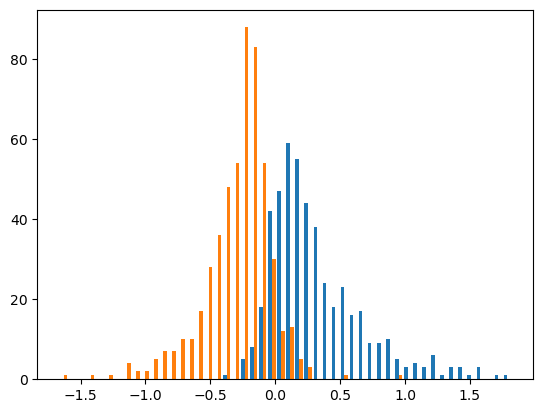

In [36]:
# plots diff scores for positive and negative examples
import matplotlib.pyplot as plt
diff_y = X_diffs[y == 1]
diff_n = X_diffs[y == 0]

plt.hist([diff_y, diff_n], bins=50, label=['positive', 'negative'])

In [37]:
# investigating mega truthy sentences
DIFF_THRESHOLD = -1.5
truthy_indices = np.where(X_diffs < DIFF_THRESHOLD)[0]

In [70]:
# samples truthy sentence
i = random.choice(truthy_indices)
subsample["content"][i]

"Returned this item as it was too large for my hallway. My fault because I didn't measure correctly, otherwise it is a good piece of furniture."

In [38]:
# converts y to (1, -1) vector
y_signs = np.where(y == 0, -1, 1)

# gets Pr[correct]
pr_correct = (X_signs.dot(y_signs) / len(y_signs) + 1) / 2
print("classifier accuracy: ", np.round(pr_correct, 2))

classifier accuracy:  0.9


In [39]:
# alternatively, just gets sklearn to do it
lr = LogisticRegression(class_weight='balanced')
lr.fit(X, y)
print("Logistic regression accuracy: {}".format(lr.score(X, y)))

Logistic regression accuracy: 0.969


(array([[  0.,   0.,   4.,   7.,  13.,  42.,  51.,  61.,  88., 211.],
        [302., 221.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]]),
 array([-0.14896262, -0.03408197,  0.08079867,  0.19567932,  0.31055996,
         0.42544061,  0.54032125,  0.65520189,  0.77008254,  0.88496318,
         0.99984383]),
 <a list of 2 BarContainer objects>)

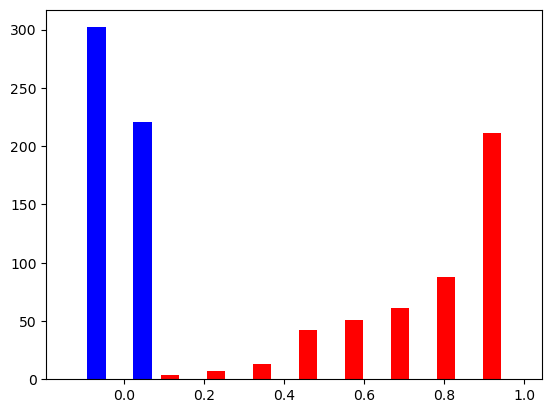

In [20]:
# plots LR predictions by class
preds = lr.predict_proba(X)[:, 1]
preds_y = preds[y == 1]
preds_n = X_diffs[y == 0]

plt.hist([preds_y, preds_n], bins=10, label=['positive', 'negative'], color = ["red", "blue"])